### 0. Import libraries & functions

In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0";
#from pudb import set_trace
import numpy as np
import torch
from torchvision import models

import torch.backends.cudnn as cudnn
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from xmodels import *
from utils_se import *

from pointwise_attack import PointWiseAtt
from spaevo_attack import SpaEvoAtt
import pgd_attacks_pt2

In [2]:
def imshow(img):
    
    npimg = img[0].cpu().numpy()
    npimg = np.transpose(npimg,(1, 2, 0))
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

In [3]:
def perturbation_heat_map(xo,xa):
    
    fig_dims = (5, 5)
    fig, ax = plt.subplots(figsize=fig_dims)
    x=torch.abs(xo-xa).sum(dim=1).cpu()[0]
    sns.heatmap(x,ax=ax,xticklabels=False, yticklabels=False,cbar = False)
    plt.show()

### 1. Load data, pretrained model, evaluation set

In [4]:
# a. Load dataset
batch_size = 1
dataset = 'imagenet' # or 'cifar10'
datapath = '../datasets/ImageNet-val'
testloader, testset = load_data(dataset,data_path=datapath,batch_size=batch_size)

/home/viet/anaconda3/envs/transformer/lib/python3.8/site-packages/torchvision/datasets/imagenet.py:50: RuntimeWarning: The use of the download flag is deprecated, since the dataset is no longer publicly accessible.
  warnings.warn(msg, RuntimeWarning)


In [5]:
# b. Load pre-trained model

# 'resnet50' if pre-trained model from Pytorch. 'resnet18' if using pre-trained cifar10 model
arch = 'resnet50' 

# None means using pre-traineded model from Pytorch or default path. Otherwise, please change model_path = '...'
model_path = None 

# True means pre-trained model does "not" normalized data while training, 
# so no need to unnorm during intergerence (used for CIFAR10 model)

if dataset == 'cifar10':
    num_classes = 10
    norm = False # True means pre-trained model does "not" normalized data while training.
    
elif dataset == 'imagenet':
    num_classes = 1000
    norm = False # True means pre-trained model does "not" normalized data while training.

net = load_model(arch,model_path)
model = PretrainedModel(net,dataset,arch,norm)

In [6]:
# c. Load evaluation set
targeted = True # True means targeted attack. False means untargeted attack.
seed = 999
ID_set = get_evalset(model,dataset,arch,testset,seed,targeted)

### 2. Pointwise Evaluation

In [52]:
i = 51#10
o = ID_set[i,1] #oID
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()
query_limit = 20000
nquery = 0
n_pix = 128#96
seed = 0

if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    timg, tlabel = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else: 
    init_mode = 'salt_pepper_att' 
    timg, nqry,_ = gen_starting_point(model,oimg,olabel,seed,dataset,init_mode)
    tlabel = None
    nquery += nqry

attack = PointWiseAtt(model,flag=targeted)

#adv, nqry, Dt = attack.pw_perturb(oimg.cpu().numpy(),timg.cpu().numpy(),olabel,tlabel,max_query=query_limit)
adv, nqry, Dt = attack.pw_perturb_multiple(oimg.cpu().numpy(),timg.cpu().numpy(),olabel,tlabel,n_pix,max_query=query_limit)
    
adv = torch.from_numpy(adv.reshape(oimg.shape)).cuda()

Source image:


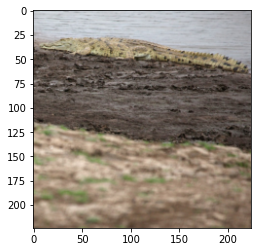

Starting image:


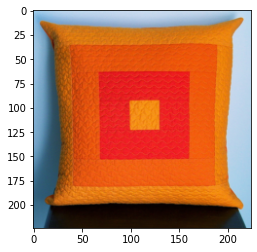

Adversarial Example:


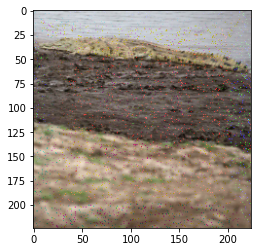

Perturbation Heat Map:


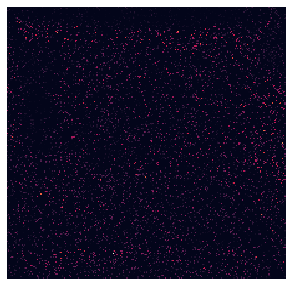

In [53]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [54]:
DPw = Dt

In [55]:
# check prediction of adversarial example
alabel = model.predict_label(adv).item()
dist = l0b(oimg,adv)# DPw[-1]
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L0 dist:{dist}')

- sample ID: 2492
- ground-truth: 49 
- target label: 721 
- AdvEx label: 721
- L0 dist:7285


### 3. PGD_L0 Evaluation

In [36]:
if dataset == 'imagenet':
    mu = (0.0, 0.0, 0.0)
    std = (1.0, 1.0, 1.0)

    if targeted:
        num_steps = 5000
        step_size = 224*224*3*(0.025)
        LB_L0 = 0
        UB_L0 = 4000
    else:
        num_steps = 2000
        step_size = 224*224*3*(0.05)
        LB_L0 = 0
        UB_L0 = 800

elif dataset == 'cifar10':
    mu = (0.0, 0.0, 0.0)
    std = (1.0, 1.0, 1.0)

    if targeted:
        num_steps = 250
        step_size = 120000.0/255.0
        LB_L0 = 0
        UB_L0 = 200
    else:
        num_steps = 100
        step_size = 120000.0/255.0
        LB_L0 = 0
        UB_L0 = 100

pgd_args = {'type_attack': 'L0',
            'n_restarts': 1,
            'num_steps': num_steps,
            'step_size': step_size,
            'epsilon': -1,
            'sparsity': 100,
            'mu': mu,
            'std':std}

i = 51#10, 113
o = ID_set[i,1] #oID
img, label = testset[o]
img = torch.unsqueeze(img, 0).cuda()
oimg = img.permute(0,2,3,1) # equal to np.transpose(img,(0,2, 3, 1))
olabel = np.expand_dims(label,axis = 0)

In [37]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

ub = UB_L0
lb = LB_L0  

while (ub - lb) > 5:
    k = int((ub + lb)//2)
       
    # 2. Run attack
    # not "net" but "model" instead because the net is drafted in PreTrainedModel 
    # and mu,std are feeded to pgd.attack with 0 & 1 since input is transformered PreTrainModel
    pgd_args['sparsity'] = k
    attack = pgd_attacks_pt2.PGDattack(model, pgd_args) 

    if targeted:
        label = np.expand_dims(ID_set[i,2],axis=0) #tcla
        tlabel = label.item()
        adv, pgd_adv_acc, pixel_changed = attack.perturb_norm_target(oimg.cpu().numpy(), label)
    else: #untaget
        label = olabel
        adv, pgd_adv_acc, pixel_changed = attack.perturb_norm(oimg.cpu().numpy(), label)
                
    adv = torch.from_numpy(adv).cuda()
    adv = adv.permute(0,3,1,2)
    alabel = model.predict_label(adv)
    if alabel.cpu().numpy()!=olabel.item():
        ub = k
        L0 = pixel_changed.item()
        alabel_fin = alabel.item()
        adv_fin = adv.clone()
        print(olabel,alabel_fin,L0,k)
    else:
        lb = k

[49] 721 2000 2000
[49] 721 1000 1000
[49] 721 500 500
[49] 721 250 250
[49] 721 125 125
[49] 721 62 62


Source image:


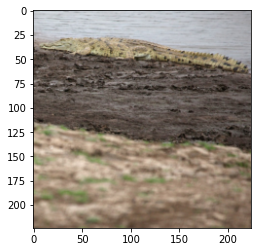

Adversarial Example:


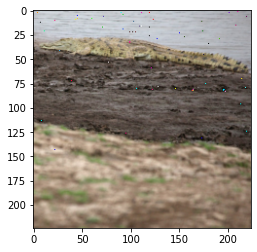

Perturbation Heat Map:


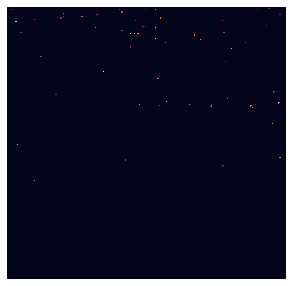

In [38]:
print('Source image:')
imshow(img)

print('Adversarial Example:')
imshow(adv_fin)

print('Perturbation Heat Map:')
perturbation_heat_map(img,adv_fin)

In [39]:
# check prediction of adversarial example
alabel = model.predict_label(adv_fin).item()
dist = l0b(oimg.permute(0,3,1,2),adv_fin)#DSpaEvo[-1]
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L0 dist:{dist}')

- sample ID: 2492
- ground-truth: [49] 
- target label: 721 
- AdvEx label: 721
- L0 dist:62


### 4. SparseEvo Evaluation

In [40]:
if dataset == 'cifar10':
    n_pix = 4 # 4, 16, 64, 256 only required for uni_rand: 4/(32*32) = 196/(224*224) = 0.004
    if targeted:
        mu = 0.01
    else:
        mu = 0.04
elif dataset == 'imagenet':
    n_pix = 196 # 49, 196, 784, 3136 only required for uni_rand: 4/(32*32) = 196/(224*224) = 0.004
    if targeted:
        mu = 0.001
    else:
        mu = 0.004

query_limit = 20000
nquery = 0
pop_size = 10
cr = 0.5
seed = 0
n = n_pix

attack = SpaEvoAtt(model,n,pop_size,cr,mu,seed,flag=targeted)

In [44]:
# change i to select sample from selected (generated) evaluation set
i = 51#10
o = ID_set[i,1] #oID
oimg, olabel = testset[o]
oimg = torch.unsqueeze(oimg, 0).cuda()

if targeted:
    t = ID_set[i,3] #tID, 3 is index acrross dataset - 4 is sample index in a class (not accross dataset)
    timg, tlabel = testset[t]
    timg = torch.unsqueeze(timg, 0).cuda()
else:
    init_mode = 'salt_pepper_att' #'gauss_rand' #'salt_pepper'
    timg, nqry,_ = gen_starting_point(model,oimg,olabel,seed,dataset,init_mode)
    tlabel = None
    nquery += nqry
    
adv, nqry,Dt = attack.evo_perturb(oimg,timg,olabel,tlabel,max_query=query_limit)

DSpaEvo = Dt

1748 5000 tensor([721], device='cuda:0')
130 10000 tensor([721], device='cuda:0')
130 15000 tensor([721], device='cuda:0')
130 20000 tensor([721], device='cuda:0')


Source image:


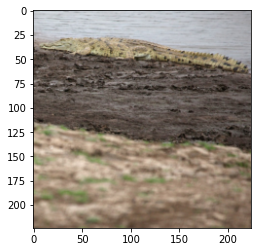

Starting image:


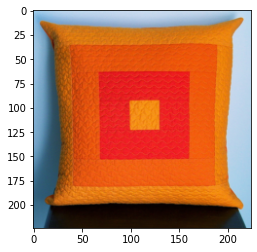

Adversarial Example:


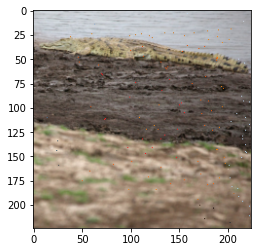

Perturbation Heat Map:


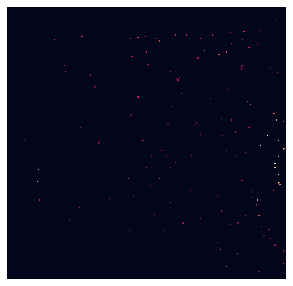

In [45]:
print('Source image:')
imshow(oimg)

print('Starting image:')
timg, _ = testset[t]
timg = torch.unsqueeze(timg, 0).cuda()
imshow(timg)

print('Adversarial Example:')
imshow(adv)

print('Perturbation Heat Map:')
perturbation_heat_map(oimg,adv)

In [46]:
# check prediction of adversarial example
alabel = model.predict_label(adv).item()
dist = l0b(oimg,adv)#DSpaEvo[-1]
print(f'- sample ID: {o}\n- ground-truth: {olabel} \n- target label: {tlabel} \n- AdvEx label: {alabel}\n- L0 dist:{dist}')

- sample ID: 2492
- ground-truth: 49 
- target label: 721 
- AdvEx label: 721
- L0 dist:130


### 6. Plot Distortion vs Queries

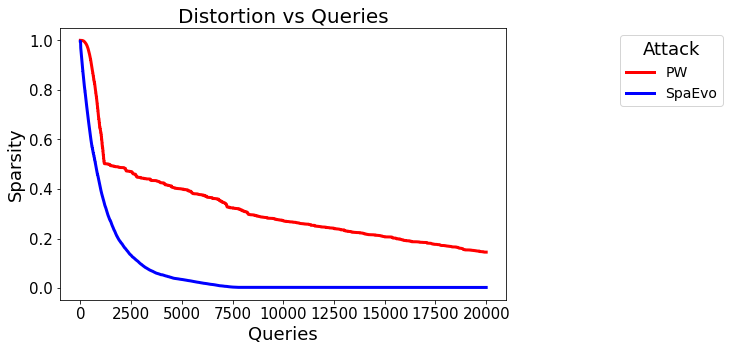

In [56]:
img_size = 224*224
nq = query_limit
q = np.arange(nq)
df = pd.DataFrame({'qry':q,'dPW':DPw[:nq]/img_size,
                   'dSpaE':DSpaEvo[:nq].cpu().numpy()/img_size})

fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
f = sns.lineplot(x = 'qry', y = 'dPW',ax=ax,linewidth = 3, color = 'red',label = 'PW',data=df)
f = sns.lineplot(x = 'qry', y = 'dSpaE',ax=ax,linewidth = 3, color = 'blue',label = 'SpaEvo',data=df)

f.axes.set_title("Distortion vs Queries",fontsize=20)
f.set_xlabel("Queries",fontsize=18)
f.set_ylabel("Sparsity",fontsize=18)
f.tick_params(labelsize=15)
#plt.legend(labels=['RamBoAttack (HSJA)'])
plt.legend(title='Attack', fontsize='14', title_fontsize='18',bbox_to_anchor= (1.5,1))
plt.show()